** Imports**

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import math

In [2]:
from costs import *
from models import *
from helpers import * 
from evaluation import *
from split_data import *
from split_features import *
from plots import *

## Data loading
** Load the training data into feature matrix, class labels, and record ids**

We write our own `load_csv_data` function to import csv data, which gives us prediction column, feature matrix and each record ID.

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'data/train.csv' # TODO: download train data and supply path here 
y, tx, ids = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)

### Split the dataset into trainset and testset in order to test accuracy

In [4]:
x_train, y_train, x_test, y_test = split_data(tx, y, 0.9)

In [5]:
x_train.shape

(225000, 30)

In [6]:
tx = x_train
y = y_train

## Data Preprocessing

### Split into 6 distinct datasets

According to our exploration, we can distinct 3 different dataset based on number of jets each experiments contains. Then each of them can be split again into 2 different datasets based on whether they have a measurable mass or not.

In [7]:
jet0, jet1, jet23, y0, y1, y23 = split_on_jets(y, tx)



### Plot each feature

### Replace all NaN mass with mean mass

In [8]:
jet0[:,0].min()

-999.0

In [9]:
mean_mass_j0 = np.mean(jet0[np.where(jet0[:,0] != -999.)][:,0])
mean_mass_j1 = np.mean(jet0[np.where(jet1[:,0] != -999.)][:,0])
mean_mass_j23 = np.mean(jet0[np.where(jet23[:,0] != -999.)][:,0])

In [10]:
jet0[np.where(jet0[:,0] == -999.), 0] = mean_mass_j0
jet1[np.where(jet1[:,0] == -999.), 0] = mean_mass_j1
jet23[np.where(jet23[:,0] == -999.), 0] = mean_mass_j23

### Only keep the features without NaN in each subset

In [11]:
jet0, selected_jet0 = select_features_without_nan(jet0)
jet1, selected_jet1 = select_features_without_nan(jet1)
jet23, selected_jet23 = select_features_without_nan(jet23)


### Outliers

<function matplotlib.pyplot.show>

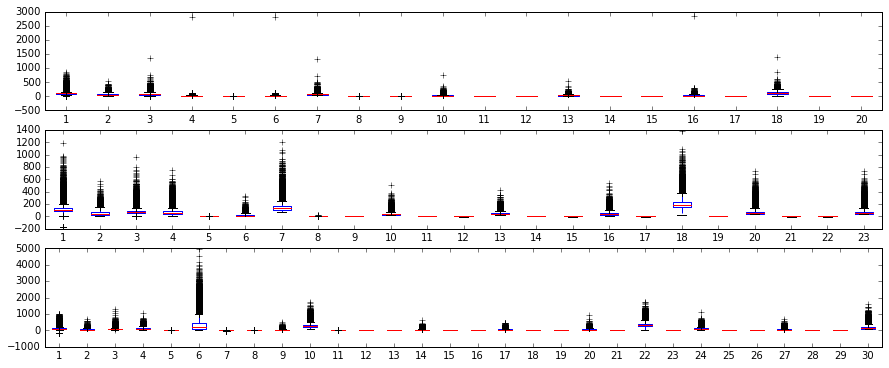

In [12]:
plt.figure(figsize=(15, 6)) 
plt.subplot(311)
plt.boxplot(jet0)
plt.subplot(312)
plt.boxplot(jet1)
plt.subplot(313)
plt.boxplot(jet23)
plt.show

In [13]:
jet0_outlier = jet0[np.where((jet0[:,3] < 1200) & (jet0[:,2]<1200))]

In [14]:
y0 = y0[np.where((jet0[:,3] < 1200) & (jet0[:,2]<1200))]
jet0 = jet0_outlier


<function matplotlib.pyplot.show>

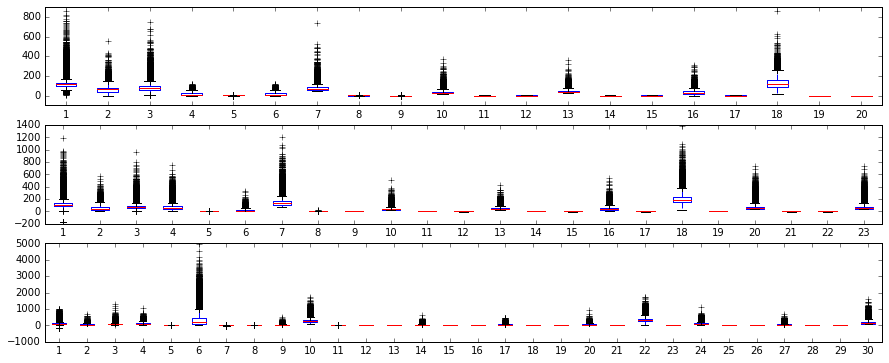

In [15]:
plt.figure(figsize=(15, 6)) 
plt.subplot(311)
plt.boxplot(jet0)
plt.subplot(312)
plt.boxplot(jet1)
plt.subplot(313)
plt.boxplot(jet23)
plt.show

### Standardization of values
We use [feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) method to standardize our feature matrix, i.e. to rescale tx down to [0, 1], so as to avoid complicated computation caused by large numbers.

In [16]:
tx = standardize(tx)

std_jet0, min0, range0 = standardize_mean(jet0)

std_jet1, min1, range1 = standardize_mean(jet1)

std_jet23, min23, range23 = standardize_mean(jet23)

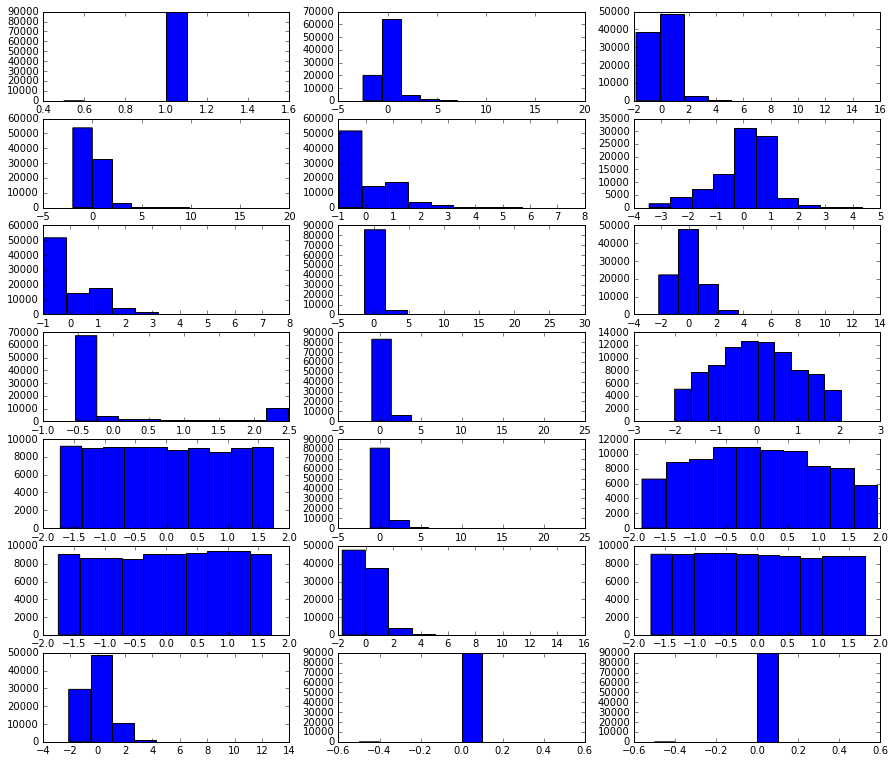

In [17]:
plot_features(std_jet0)

### build polynomial matrix

In [31]:
from poly import *
degree0, degree1, degree23 = 5, 10, 6
poly_std_jet0 = build_poly(std_jet0, degree0)
poly_std_jet1 = build_poly(std_jet1, degree1)
poly_std_jet23 = build_poly(std_jet23, degree23)

## Machine Learning

In [54]:
np.logspace(-10, 0, 5)

array([  1.00000000e-10,   3.16227766e-08,   1.00000000e-05,
         3.16227766e-03,   1.00000000e+00])

In [59]:
degrees = np.linspace(3, 10, 8) 
lambdas = np.logspace(-10, 0, 5)
parameters = []
losses = []
accuracies = []
for d in degrees:
    for l in lambdas:
        poly_std_jet0 = build_poly(std_jet0, int(d))
        loss, accuracy = cross_validation(y0, poly_std_jet0, 4, 1, ridge_regression, l)
        parameters.append([d, l])
        losses.append(loss)
        accuracies.append(accuracy)
        
        

In [61]:
losses

[0.34873869186928474,
 0.34874735280199387,
 0.34874743877655484,
 0.34896120606135306,
 0.37356453332205697,
 0.34648162856644849,
 0.34649178256294316,
 0.34649341474901135,
 0.34685276287256378,
 0.37103217335314764,
 0.34440303850048232,
 0.34440985491818887,
 0.34441673047523247,
 0.34474697392523057,
 0.36952491679600802,
 0.34332642980203593,
 0.34333399233643086,
 0.34334443651481128,
 0.34359799182829398,
 0.36634659228511002,
 0.34154111701055234,
 0.34144167038310169,
 0.34144647517467086,
 0.34163607048474193,
 0.36477238290280967,
 0.33991161843501683,
 0.33991594598608632,
 0.33992665667631222,
 0.34013108753282528,
 0.36431810800157677,
 0.33921038082858374,
 0.33921129327029992,
 0.33922737323213731,
 0.33948880064084075,
 0.363893300133944,
 0.51960406380081658,
 0.34471716528305607,
 0.33893084025777342,
 0.33922319117824046,
 0.36405844903146367]

### Logistic Regression

Choose intial parameters

In [32]:
n_iters = 10000
gamma = 0.000003


Train with logistic regression

In [33]:
lambda_ = 0.001
print("w0")
loss0, w0 = ridge_regression(y0, poly_std_jet0, lambda_)
print("loss = ", loss0)

print("w1")
loss1, w1 = ridge_regression(y1, poly_std_jet1, lambda_)
print("loss = ", loss1)

print("w23")
loss23, w23 = ridge_regression(y23, poly_std_jet23, lambda_)
print("loss = ", loss23)

w0
loss =  0.344837724693
w1
loss =  0.384780856178
w23
loss =  0.381769501749


In [34]:
w0.shape

(126,)

In [35]:
w1.shape

(264,)

In [36]:
w23.shape

(217,)

In [37]:
selected_jet23.shape

(30,)

In [38]:
std_jet23.shape

(65286, 31)

## Accuracy testing against virtual test_set

In [39]:
testset = x_test


y_pred = apply_right_model_withoutmass_ridge(testset, \
                  selected_jet0, selected_jet1, \
                  selected_jet23, \
                  min0, min1, min23, \
                  range0, range1, range23, \
                  w0, w1, w23, degree0, degree1, degree23)


In [40]:
y_pred.shape

(25000,)

In [42]:
test_accuracy(y_test, y_pred)

0.476

## Output prediction to Kaggle

In [29]:
test_x = np.genfromtxt('data/test.csv', delimiter=',', skip_header=1)

In [30]:
ids = test_x[:, 0]
testset = test_x[:, 2:] # remove id and prediction columns

y = []

for x_t in testset:
    x = np.array([x_t])
    if isJet0_nomass(x):
        pred = x[:,selected_jet0_nomass]
        pred, _ , _ = standardize(pred, min0_nomass, range0_nomass)
        y.append(log_reg_predict(pred, w0_nomass))
    elif isJet0(x):
        pred = x[:, selected_jet0]
        pred, _ , _  = standardize(pred, min0, range0)
        y.append(log_reg_predict(pred, w0))
    elif isJet1_nomass(x):
        pred = x[:, selected_jet1_nomass]
        pred, _ , _  = standardize(pred,min1_nomass, range1_nomass)
        y.append(log_reg_predict(pred, w1_nomass))
    elif isJet1(x):
        pred = x[:, selected_jet1]
        pred, _ , _  = standardize(pred, min1, range1)
        y.append(log_reg_predict(pred, w1))
    elif isJet23_nomass(x):
        pred= x[:, selected_jet23_nomass]
        pred, _ , _  = standardize(pred, min23_nomass, range23_nomass)
        y.append(log_reg_predict(pred, w23_nomass))
    else:
        pred= x[:, selected_jet23]
        pred, _ , _  = standardize(pred, min23, range23)
        y.append(log_reg_predict(pred, w23))


NameError: name 'selected_jet0_nomass' is not defined

In [ ]:
create_csv_submission(ids, y, 'data/split_data.csv')

In [ ]:
ids = test_x[:, 0]
testset = test_x[:, 2:] # remove id and prediction columns

jet0_nm_ids = np.where((testset[:,22] == 0) & (testset[:,0] == -999.))[0]
jet0_ids = np.where((testset[:,22] == 0) & (testset[:,0] != -999.))[0]
jet1_nm_ids = np.where((testset[:,22] == 1) & (testset[:,0] == -999.))[0]
jet1_ids = np.where((testset[:,22] == 1) & (testset[:,0] != -999.))[0]
jet23_nm_ids = np.where(((testset[:,22] == 2) | (testset[:,22] == 3)) \
                        & (testset[:,0] == -999.))[0]
jet23_ids = np.where(((testset[:,22] == 2) | (testset[:,22] == 3)) \
                        & (testset[:,0] != -999.))[0]

jet0_test_nm = testset[jet0_nm_ids][:, selected_jet0_nomass]
jet0_test = testset[jet0_ids][:, selected_jet0]
jet1_test_nm = testset[jet1_nm_ids][:, selected_jet1_nomass]
jet1_test = testset[jet1_ids][:, selected_jet1]
jet23_test_nm = testset[jet23_nm_ids][:, selected_jet23_nomass]
jet23_test = testset[jet23_ids][:, selected_jet23]

higgs_jet0_nm = np.where(log_reg_predict(jet0_test_nm, w0_nomass) == 1)[0]
higgs_jet0 = np.where(log_reg_predict(jet0_test, w0) == 1)[0]
higgs_jet1_nm = np.where(log_reg_predict(jet1_test_nm, w1_nomass) == 1)[0]
higgs_jet1 = np.where(log_reg_predict(jet1_test, w1) == 1)[0]
higgs_jet23_nm = np.where(log_reg_predict(jet23_test_nm, w23_nomass) == 1)[0]
higgs_jet23 = np.where(log_reg_predict(jet23_test, w23) == 1)[0]


### retrieve the id's of higgs boson

In [ ]:
import itertools

higgs = itertools.chain(ids[jet0_nm_ids][higgs_jet0_nm], ids[jet0_ids][higgs_jet0] \
               , ids[jet1_nm_ids][higgs_jet1_nm], ids[jet1_ids][higgs_jet1]\
               , ids[jet23_nm_ids][higgs_jet23_nm], ids[jet23_ids][higgs_jet23])

higgs_arr = list([int(i) for i in higgs])

In [ ]:
res = []
for i in range(350000,918238):
    if i in higgs_arr:
        res.append([i, 1])
    else:
        res.append([i, -1])
        
res

In [ ]:
prediction = apply_right_model(testset, ids, w0_nomass, w0, w1_nomass, ...
                               w1, w23_nomass, w23, selected_jet0_nomass, ...
                              selected_jet0, selected_jet1_nomass, selected_jet1, ...
                              selected_jet23_nomass, selected_jet23)
prediction

In [ ]:
print("higgs: ", np.count_nonzero(prediction == 1))
print("non-higgs: ", np.count_nonzero(prediction == -1))

In [ ]:
test_x = np.genfromtxt('data/test.csv', delimiter=',', skip_header=1)
test_x = standardize(test_x[:, 2:])  # remove id and prediction columns
# could've used load_csv_data
create_csv_submission([i for i in range(350000,918238)], log_reg_predict(test_x, w), 'res.csv')

In [ ]:
test_jet0

## Feature Engineering
TODO

## Prediction

**Generate predictions and save ouput in csv format for submission**